Stock Price Prediction using LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [81]:
cd ..

/


In [82]:
!ls

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [83]:
import os
os.chdir("content/drive/MyDrive/Sequence_Models")

Import Libraries

In [84]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

Reading data and concise summary

In [85]:
filename = "GOOG.csv"
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216 entries, 0 to 4215
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4216 non-null   object 
 1   Open       4216 non-null   float64
 2   High       4216 non-null   float64
 3   Low        4216 non-null   float64
 4   Close      4216 non-null   float64
 5   Adj Close  4216 non-null   float64
 6   Volume     4216 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 230.7+ KB
None


We only require date and close columns

In [86]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True) #Reset index
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

Visualize data - https://machinelearningmastery.com/time-series-data-visualization-with-python/

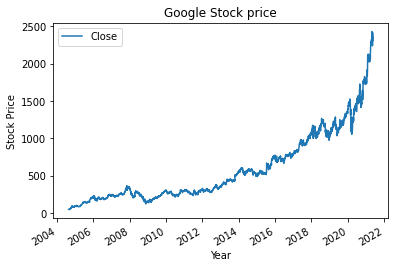

In [87]:
from matplotlib import pyplot as plt
df_copy = df.copy()
df_copy.drop(columns=['Date'], inplace = True)
df_copy.plot()

plt.title('Google Stock price')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.show()

Preprocessing - Train Test Split

In [88]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

close_date = df['Date']
#close_date = close_date.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

3372
844


Convert sequence to Supervised data using Timeseriesgenerator module

In [89]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)


Model Training 

In [90]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
168/168 [==============================] - 2s 4ms/step - loss: 151046.5260
Epoch 2/25
168/168 [==============================] - 1s 4ms/step - loss: 226.8117
Epoch 3/25
168/168 [==============================] - 1s 4ms/step - loss: 48.8950
Epoch 4/25
168/168 [==============================] - 1s 4ms/step - loss: 62.9046
Epoch 5/25
168/168 [==============================] - 1s 4ms/step - loss: 58.9088
Epoch 6/25
168/168 [==============================] - 1s 4ms/step - loss: 46.2434
Epoch 7/25
168/168 [==============================] - 1s 4ms/step - loss: 55.2673
Epoch 8/25
168/168 [==============================] - 1s 4ms/step - loss: 56.3280
Epoch 9/25
168/168 [==============================] - 1s 4ms/step - loss: 70.4626
Epoch 10/25
168/168 [==============================] - 1s 4ms/step - loss: 62.3570
Epoch 11/25
168/168 [==============================] - 1s 4ms/step - loss: 56.4596
Epoch 12/25
168/168 [==============================] - 1s 4ms/step - loss: 62.3140
Epoch 13

In [91]:
print(close_train.shape)
print(date_train.shape)

(3372, 1)
(3372,)


In [92]:
print(close_data.shape)
print(close_date.shape)

(4216, 1)
(4216,)


In [93]:
#import plotly.plotly as py
import plotly.graph_objs as go

prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

Prediction for next 30 days

In [94]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [95]:
#%%
#import plotly.plotly as py
import plotly.graph_objs as go

#prediction = model.predict(test_generator)

close_data = close_data.reshape((-1))
forecast = forecast.reshape((-1))
#prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = close_date,
    y = close_data,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecast'
)

layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()